In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v011.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [3]:
import sys, os
import numpy as np

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../param_search')
%aimport param_search
ps = param_search

Using backend: pytorch



# Evaluating the noise robustness of PINNs compared to direct method

Using 2D single-frequency PINNs vs. direct Helmholtz inversion

In [10]:
# define the job template and name format

template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
source activate MRE-PINN

python ../../../train.py \\
    --data_root ../../../data/BIOQIC \\
    --data_name fem_box \\
    --frequency {frequency} \\
    --xyz_slice {xyz_slice} \\
    --noise_ratio {noise_ratio} \\
    --pde_name {pde_name} \\
    --omega0 {omega0} \\
    --n_layers {n_layers} \\
    --n_hidden {n_hidden} \\
    --activ_fn {activ_fn} \\
    --learning_rate {learning_rate} \\
    --pde_loss_wt {pde_loss_wt} \\
    --data_loss_wt {data_loss_wt} \\
    --batch_size {batch_size} \\
    --n_domain {n_domain} \\
    --n_iters {n_iters} \\
    --test_every {test_every} \\
    --save_every {save_every} \\
    --save_prefix {job_name}    
'''
name = 'train_{frequency}_{xyz_slice}_{pde_name}_{noise_ratio}'

# define the parameter space

param_space = ps.ParamSpace(
    frequency=[50, 60, 70, 80, 90, 100],
    xyz_slice=['2D'],
    noise_ratio=[0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    pde_name=['helmholtz', 'hetero'],
    omega0=[8],
    n_layers=[5],
    n_hidden=[256],
    activ_fn=['s'],
    learning_rate=1e-4,
    pde_loss_wt=1e-8,
    data_loss_wt=1,
    batch_size=80,
    n_domain=128-80,
    pde_distrib='uniform',
    n_iters=100000,
    test_every=1000,
    save_every=10000
)

len(param_space)

72

In [5]:
%autoreload
expt_name = '2022-07-27_noise'

#jobs = ps.submit(template, name, param_space, work_dir=expt_name, verbose=True)
#jobs.to_csv(f'{expt_name}.jobs')

import pandas as pd
jobs = pd.read_csv(f'{expt_name}.jobs')

In [6]:
status_cols = ['job_name', 'job_state', 'node_id', 'runtime', 'stdout', 'stderr']
ps.status(jobs)[status_cols]

,job_name,job_state,node_id,runtime,stdout,stderr
job_id,,,,,,
10021105,train_50_2D_helmholtz_0,NaN,NaN,NaN,None,None
10021106,train_50_2D_hetero_0,NaN,NaN,NaN,None,None
10021107,train_50_2D_helmholtz_1e-05,NaN,NaN,NaN,None,None
10021108,train_50_2D_hetero_1e-05,NaN,NaN,NaN,None,None
10021109,train_50_2D_helmholtz_0.0001,NaN,NaN,NaN,None,None
...,...,...,...,...,...,...
10021172,train_100_2D_hetero_0.001,NaN,NaN,NaN,None,None
10021173,train_100_2D_helmholtz_0.01,NaN,NaN,NaN,None,None
10021174,train_100_2D_hetero_0.01,NaN,NaN,NaN,None,None


In [8]:
metrics = ps.metrics(jobs)

# did all models train to 100k iterations?
assert (metrics.groupby('job_name')['iteration'].max() == 100e3).all()

param_cols = ['frequency', 'pde_name', 'noise_ratio'] # experimental parameters
index_cols = ['iteration', 'variable_name', 'spatial_frequency_bin', 'spatial_region'] # metric identifiers
metric_cols = ['mean_squared_abs_value', 'power_density', 'mean_abs_value'] # metric values

metrics = metrics.groupby(['job_name'] + param_cols + index_cols, sort=False)[metric_cols].mean().unstack(level=[5])

def metric_map(t):
    metric_name, var_name = t
    metric_name = {
        'mean_squared_abs_value': 'MSAV',
        'mean_abs_value': 'MAV',
        'power_density': 'SPD'
    }[metric_name]
    new_col_name = f'{var_name}_{metric_name}'
    new_col_name = new_col_name.replace('diff_MSAV', 'pred_MSAE')
    new_col_name = new_col_name.replace('f_sum_MSAV', 'PDE_MSAE')
    new_col_name = new_col_name.replace('diff_MAV', 'pred_MAD')
    return new_col_name

metrics.columns = [metric_map(t) for t in metrics.columns.to_flat_index()]

m = metrics.reset_index()
metrics

u_pred_MSAV  \
job_name                frequency pde_name  noise_ratio iteration spatial_frequency_bin spatial_region                 
train_50_2D_helmholtz_0 50        helmholtz 0.0         0         all                   all             3.431942e-10   
                                                                                        0                        NaN   
                                                                                        1                        NaN   
                                                                                        2                        NaN   
                                                                                        3                        NaN   
...                                                                                                              ...   
train_100_2D_hetero_0.1 100       hetero    0.1         100000    6.0                   all                      NaN   
                                                                  7.0                   all                      NaN   
                                                                  8.0                   all                      NaN   
                                                                  9.0                   all                      NaN   
                                                                  10.0                  all                      NaN   

                                                                                                         u_pred_MSAE  \
job_name                frequency pde_name  noise_ratio iteration spatial_frequency_bin spatial_region                 
train_50_2D_helmholtz_0 50        helmholtz 0.0         0         all                   all             5.033846e-10   
                                                                                        0                        NaN   
                                                                                        1                        NaN   
                                                                                        2                        NaN   
                                                                                        3                        NaN   
...                                                                                                              ...   
train_100_2D_hetero_0.1 100       hetero    0.1         100000    6.0                   all                      NaN   
                                                                  7.0                   all                      NaN   
                                                                  8.0                   all                      NaN   
                                                                  9.0                   all                      NaN   
                                                                  10.0                  all                      NaN   

                                                                                                         u_true_MSAV  \
job_name                frequency pde_name  noise_ratio iteration spatial_frequency_bin spatial_region                 
train_50_2D_helmholtz_0 50        helmholtz 0.0         0         all                   all             1.544610e-10   
                                                                                        0                        NaN   
                                                                                        1                        NaN   
                                                                                        2                        NaN   
                                                                                        3                        NaN   
...                                                                                                              ...   
train_100_2D_hetero_0.1

<IPython.core.display.Javascript object>


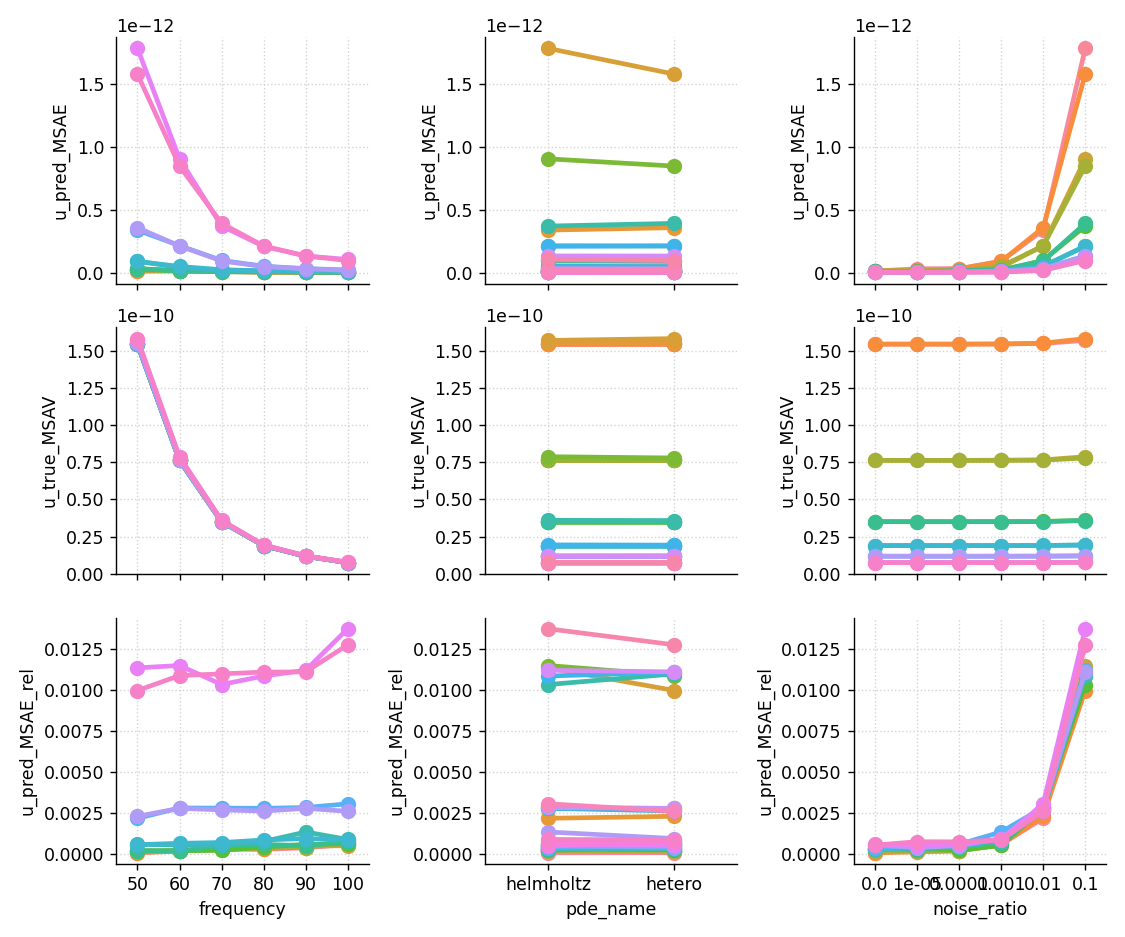

In [9]:
# wave field fitting

m['u_pred_MSAE_rel'] = m['u_pred_MSAE'] / m['u_true_MSAV']

fig = ps.plot(
    m[m.iteration == 100e3].copy(),
    x=param_cols,
    y=['u_pred_MSAE', 'u_true_MSAV', 'u_pred_MSAE_rel'],
    height=2.5,
    width=3,
    legend=False,
    tight=True
)

The most evident trend is worse wave field quality at higher noise ratios, which was expected.

In [20]:
bin_size = 1e4
m['iteration_bin'] = (m.iteration // bin_size) * bin_size
m

,job_name,frequency,pde_name,noise_ratio,iteration,spatial_frequency_bin,spatial_region,u_pred_MSAV,u_pred_MSAE,u_true_MSAV,...,mu_true_MAV,Mu_MAV,Mu_pred_MAD,u_pred_MSAE_rel,iteration_bin,mu_pred_MAD_rel,"pde_name, noise_ratio","frequency, noise_ratio","frequency, pde_name",
0,train_50_2D_helmholtz_0,50,helmholtz,0.0,0,all,all,3.431942e-10,5.033846e-10,1.544610e-10,...,NaN,NaN,NaN,3.258975,0.0,NaN,"helmholtz, 0.0","50, 0.0","50, helmholtz",
1,train_50_2D_helmholtz_0,50,helmholtz,0.0,0,all,0,NaN,NaN,NaN,...,3000.000000,3095.856688,932.524948,NaN,0.0,0.261913,"helmholtz, 0.0","50, 0.0","50, helmholtz",
2,train_50_2D_helmholtz_0,50,helmholtz,0.0,0,all,1,NaN,NaN,NaN,...,8501.567747,5563.445567,2388.903533,NaN,0.0,0.688692,"helmholtz, 0.0","50, 0.0","50, helmholtz",
3,train_50_2D_helmholtz_0,50,helmholtz,0.0,0,all,2,NaN,NaN,NaN,...,4674.349093,3313.875999,1993.467599,NaN,0.0,0.373474,"helmholtz, 0.0","50, 0.0","50, helmholtz",
4,train_50_2D_helmholtz_0,50,helmholtz,0.0,0,all,3,NaN,NaN,NaN,...,3392.573995,1967.396785,1866.314068,NaN,0.0,0.286534,"helmholtz, 0.0","50, 0.0","50, helmholtz",
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116347,train_100_2D_hetero_0.1,100,hetero,0.1,100000,6.0,all,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,100000.0,NaN,"hetero, 0.1","100, 0.1","100, hetero",
116348,train_100_2D_hetero_0.1,100,hetero,0.1,100000,7.0,all,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,100000.0,NaN,"hetero, 0.1","100, 0.1","100, hetero",
116349,train_100_2D_hetero_0.1,100,hetero,0.1,100000,8.0,all,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,100000.0,NaN,"hetero, 0.1","100, 0.1","100, hetero",
116350,train_100_2D_hetero_0.1,100,hetero,0.1,100000,9.0,all,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,100000.0,NaN,"hetero, 0.1","100, 0.1","100, hetero",


<IPython.core.display.Javascript object>


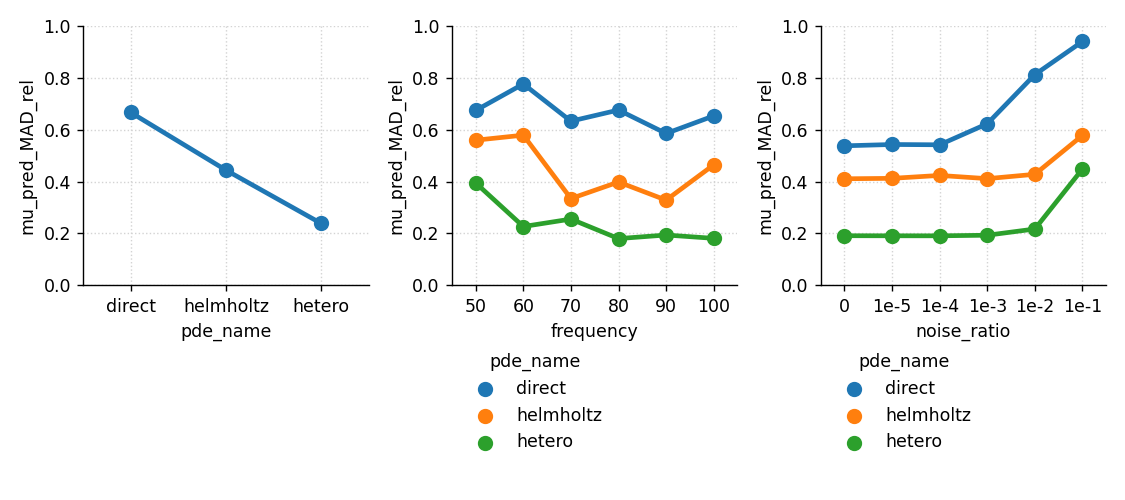

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [37]:
# elasticity reconstruction

m['mu_pred_MAD_rel'] = m['mu_pred_MAD'] / m['mu_true_MAV']

p = m.copy()
p['mu_pred_MAD_rel'] = p['Mu_pred_MAD'] / m['mu_true_MAV']
p['pde_name'] = 'direct'
p = pd.concat([p, m])

#sns.set_palette('tab10')

fig = ps.plot(
    p,
    x=['pde_name', 'frequency', 'noise_ratio'],
    y=['mu_pred_MAD_rel'],
    height=4,
    width=3,
    hue='pde_name',
    legend=True,
    tight=True,
    ylim={'mu_pred_MAD_rel': [0,1]}
)
fig.axes[2].set_xticklabels(['0', '1e-5', '1e-4', '1e-3', '1e-2', '1e-1'])
fig.savefig('noise_experiment_mu_pred_MAD_by_pde_name.png', dpi=200, bbox_inches='tight')

We can see that the PINN outperforms the baseline method (direct Helmholtz inversion) in both cases, but the heterogeneous PDE performs superior to the Helmholtz PDE. This trend is the same regardless of which frequency wave image is used. In addition it is the same regardless of the amount of noise we use to corrupt the wave image. Furthermore, it appears the PINN approach is more robust to noise because performance is only seriously affected at noise ratio of 0.1 for both PDEs, whereas direct inversion performance is badly affected by noise even at a noise ratio of 1e-3.

<IPython.core.display.Javascript object>


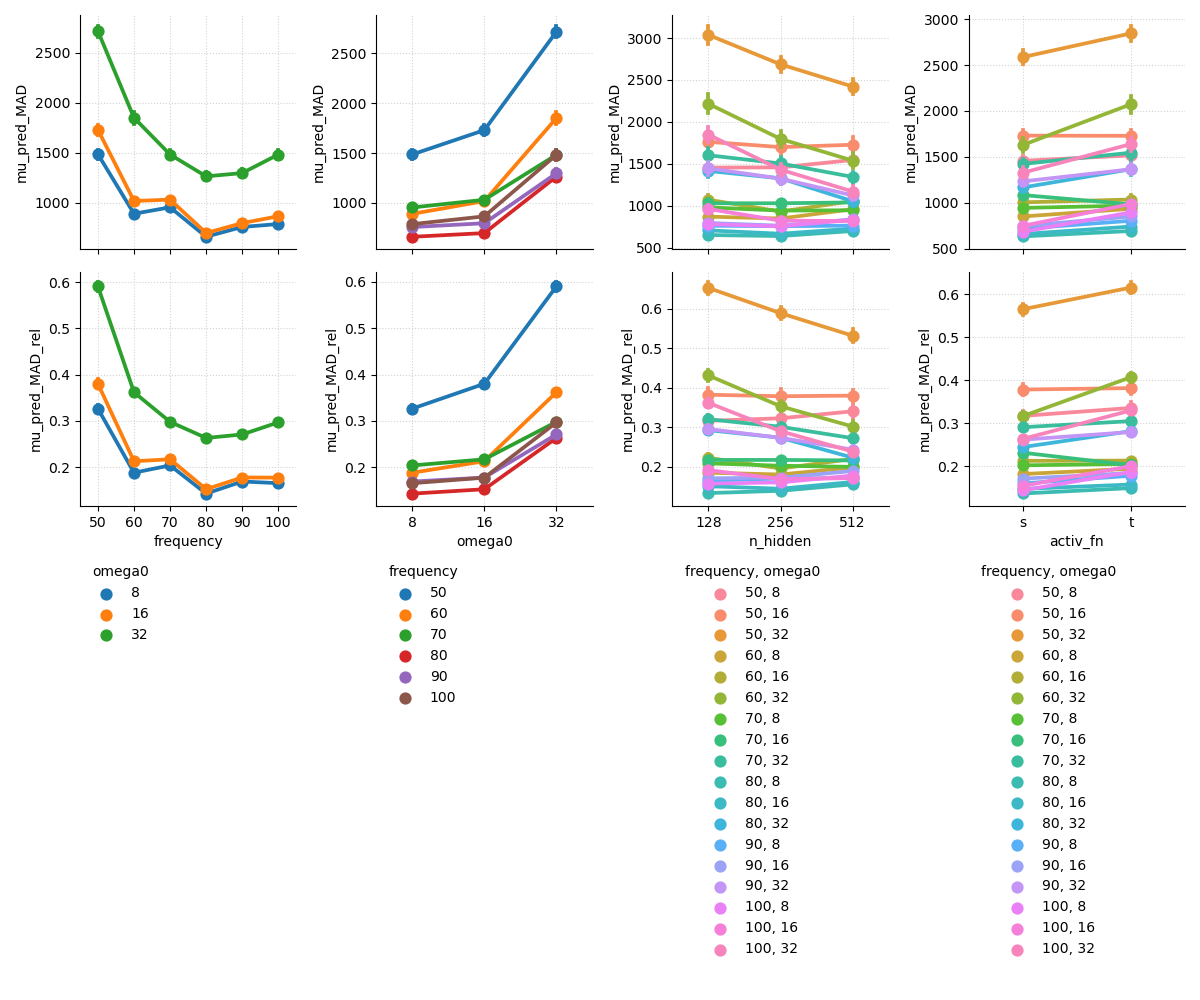

In [93]:
fig = ps.plot(
    m,
    x=param_cols,
    y=['mu_pred_MAD', 'mu_pred_MAD_rel'],
    height=5,
    width=3,
    hue=('frequency', 'omega0'),
    legend=True,
    tight=True
)
fig.savefig('2d_experiment_mu_pred_MAD_by_freq.png', dpi=200, bbox_inches='tight')

<IPython.core.display.Javascript object>


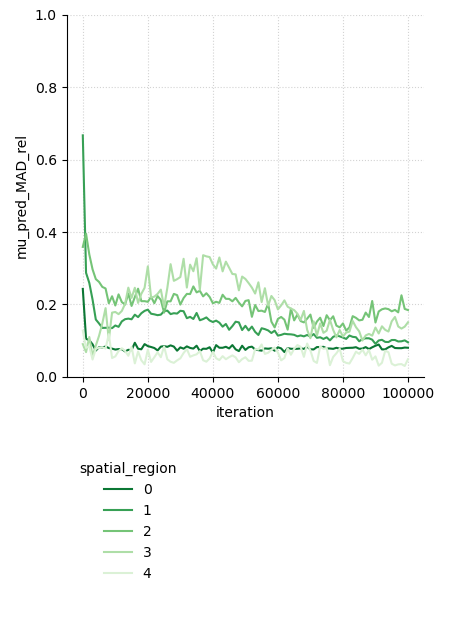

<IPython.core.display.Javascript object>


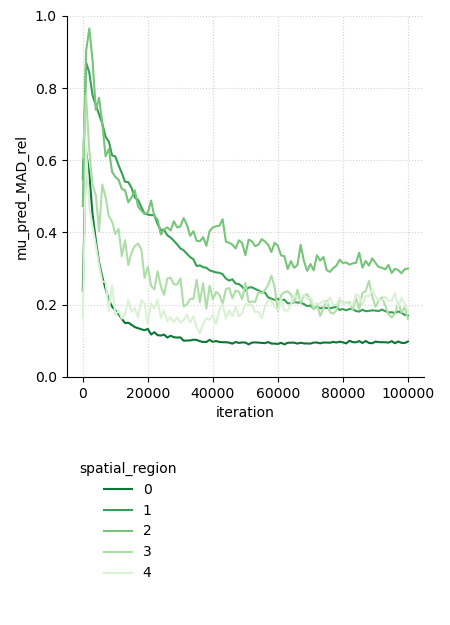

In [102]:
sns.set_palette('Greens_r', 5)

fig = ps.plot(
    m[(m.job_name == 'train_100_2D_hetero_8_256_s') & (m.spatial_region != 'all')].copy(),
    x='iteration',
    y=['mu_pred_MAD_rel'],
    hue=('spatial_region'),
    height=6.25,
    width=4.5,
    legend=True,
    tight=True,
    plot_func=sns.lineplot,
)
for ax in fig.axes:
    #ax.set_yscale('log')
    ax.set_ylim(0, 1)
    pass
fig.savefig('2d_experiment_mu_pred_MAD_8.png', dpi=200, bbox_inches='tight')

fig = ps.plot(
    m[(m.job_name == 'train_100_2D_hetero_32_256_s') & (m.spatial_region != 'all')].copy(),
    x='iteration',
    y=['mu_pred_MAD_rel'],
    hue=('spatial_region'),
    height=6.25,
    width=4.5,
    legend=True,
    tight=True,
    plot_func=sns.lineplot,
)
for ax in fig.axes:
    #ax.set_yscale('log')
    ax.set_ylim(0, 1)
    pass
fig.savefig('2d_experiment_mu_pred_MAD_32.png', dpi=200, bbox_inches='tight')